In [1]:
import random
import lr_scheduler
import matplotlib.pyplot as plt
#from func import *
import func
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from PIL import Image
import cv2
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.initializers import GlorotUniform
from PIL import Image, ImageEnhance

folder_path = "F:/code/barlow/UR5"
file_pairs = func.load_file_pairs(folder_path)

images = []
npy_file = []
for jpg_path, npy_path in file_pairs:
    images.append(func.read_jpg_files(jpg_path))
    npy_file.append(func.read_and_parse_npy_file(npy_path))

In [2]:
AUTO = tf.data.AUTOTUNE
CROP_TO = 32
SEED = 42

PROJECT_DIM = 2048
BATCH_SIZE = 32
EPOCHS = 10

### Traning

In [3]:
# Augmentation Functions

def augment_image(image, crop_ratio=0.05):
    h, w = image.shape
    # Calculate crop dimensions
    crop_h = int(h * crop_ratio)
    crop_w = int(w * crop_ratio)

    # cropping
    cropped_image = image[crop_h:h-crop_h, crop_w:w-crop_w]

    # Resize back to original
    resized_image = cv2.resize(cropped_image, (w, h), interpolation=cv2.INTER_LINEAR)

    return resized_image

# No2. Augmentation Functions
def adjust_brightness(image, factor=1.1):
    """
    scale pixel values
    """
    adjusted = np.clip(image * factor, 0, 255).astype(np.uint8)
    return adjusted

def add_noise_vector(vector,alpha= 0.01):
    noise = np.random.normal(0, alpha, size=len(vector)) # alpha standard deviation
    augmented_vector = [v + n for v, n in zip(vector, noise)]
    #augmented_vector = [i.astype(float) for i in augmented_vector]
    return augmented_vector


In [4]:
STEPS_PER_EPOCH = 597 // BATCH_SIZE
TOTAL_STEPS = STEPS_PER_EPOCH * EPOCHS
WARMUP_EPOCHS = int(EPOCHS * 0.1)
WARMUP_STEPS = int(WARMUP_EPOCHS * STEPS_PER_EPOCH)

In [5]:
# create train loss data
scaler = StandardScaler()

# image
image1 = [augment_image(img) for img in images]
image2 = [adjust_brightness(img, factor=1.2) for img in images]

# noise
npy_file_1 = [add_noise_vector(i,alpha= 0.05) for i in npy_file]
npy_file_2 = [add_noise_vector(i,alpha= 0.10) for i in npy_file]

# Normalize
image1 = [(i.astype("float32") / 255.0) for i in image1]
image2 = [(i.astype("float32") / 255.0) for i in image2]
npy_file_1 = scaler.fit_transform(npy_file_1)
npy_file_2 = scaler.fit_transform(npy_file_2)


img_ds_1 = tf.data.Dataset.from_tensor_slices(image1).batch(BATCH_SIZE)
img_ds_2 = tf.data.Dataset.from_tensor_slices(image2).batch(BATCH_SIZE)
npy_ds_1 = tf.data.Dataset.from_tensor_slices(npy_file_1).batch(BATCH_SIZE)
npy_ds_2 = tf.data.Dataset.from_tensor_slices(npy_file_2).batch(BATCH_SIZE)

# Combine image và vector thành input pairs
BL_ds = tf.data.Dataset.zip((img_ds_1, img_ds_2, npy_ds_1, npy_ds_2)).prefetch(tf.data.AUTOTUNE)
BL_ds_test = BL_ds

In [6]:
for batch in BL_ds_test.take(1):
    (x1, x2, y1, y2) = batch
    print("Image 1 shape:", x1.shape)  
    print("Image 2 shape:", x2.shape)  
    print("Vector 1 shape:", y1.shape)  
    print("Vector 2 shape:", y2.shape)  

Image 1 shape: (32, 128, 128)
Image 2 shape: (32, 128, 128)
Vector 1 shape: (32, 8)
Vector 2 shape: (32, 8)


In [7]:
# Barlow Twin Loss
def off_diagonal(x):
    n = tf.shape(x)[0]
    flattened = tf.reshape(x, [-1])[:-1]
    off_diagonals = tf.reshape(flattened, (n - 1, n + 1))[:, 1:]
    return tf.reshape(off_diagonals, [-1])

def normalize_repr(z):
    z_norm = (z - tf.reduce_mean(z, axis=0)) / (tf.math.reduce_std(z, axis=0) + 1e-8)
    return z_norm

def compute_loss(z_a, z_b, lambd = 5e-3):
    batch_size = tf.cast(tf.shape(z_a)[0], z_a.dtype)
    repr_dim = tf.shape(z_a)[1]

    # Normalize the representations along the batch dimension.
    z_a_norm = normalize_repr(z_a)
    z_b_norm = normalize_repr(z_b)

    # Cross-correlation matrix.
    c = tf.matmul(z_a_norm, z_b_norm, transpose_a=True) / batch_size

    # Loss.
    on_diag = tf.linalg.diag_part(c) + (-1)
    on_diag = tf.reduce_sum(tf.pow(on_diag, 2))
    off_diag = off_diagonal(c)
    off_diag = tf.reduce_sum(tf.pow(off_diag, 2))
    loss = on_diag + (lambd * off_diag)
    return loss   


In [8]:
def network_1():
    inputs = layers.Input(shape=(128, 128, 1), name="image_input") 
    x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(100, activation="relu")(x)  # Image embedding
    return tf.keras.Model(inputs, outputs, name="ImageNetwork")

def network_2():
    inputs = layers.Input(shape=(8,), name="npy_input")
    outputs = tf.keras.layers.Dense(10, activation="relu")(inputs)  # Joint embedding
    return tf.keras.Model(inputs, outputs, name="JointStateNetwork")


def combined_model():
    image_input = layers.Input(shape=(128, 128, 1), name="image_input")
    npy_input = layers.Input(shape=(8,), name="npy_input")
    
    image_output = network_1()(image_input)
    npy_output = network_2()(npy_input)
    
    combined = layers.Concatenate()([image_output, npy_output])
    latent_space = layers.Dense(100, activation="relu", name="latent_space")(combined)
    
    return tf.keras.Model(inputs=[image_input, npy_input], outputs=latent_space, name="CombinedModel")

@tf.function
def train_step(image1, image2, npy1, npy2, network1, network2, optimizer, lambda1, lambda2):
    with tf.GradientTape() as tape:
        # Forward pass for images
        z_img1 = network1(image1, training=True)
        z_img2 = network1(image2, training=True)
        loss1 = compute_loss(z_img1, z_img2)

        # Forward pass for joints
        z_npy1 = network2(npy1, training=True)
        z_npy2 = network2(npy2, training=True)
        loss2 = compute_loss(z_npy1, z_npy2)

        # Total loss
        # with lambda = 1/Dimension
        total_loss = loss1 * lambda1 + loss2 * lambda2
    
    gradients = tape.gradient(total_loss, network1.trainable_variables + network2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, network1.trainable_variables + network2.trainable_variables))
    
    return {"loss_total": total_loss, "loss1": loss1, "loss2": loss2}


In [9]:
lr_decayed_fn = lr_scheduler.WarmUpCosine(
    learning_rate_base=1e-4,
    total_steps=EPOCHS * STEPS_PER_EPOCH,
    warmup_learning_rate=0.0,
    warmup_steps=WARMUP_STEPS
)

#lr_decayed_fn = 5e-4     # 0.005 = 5e-3

model = combined_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn, momentum=0.9)
lambd = 5e-3 
EPOCHS = 20
lambda1 = 1/10
lambda2 = 1
network1 = network_1()
network2 = network_2()

for epoch in range(EPOCHS):
    for image1_batch, image2_batch, npy1_batch, npy2_batch in BL_ds_test:
        losses = train_step(image1_batch, image2_batch, npy1_batch, npy2_batch, network1, network2, optimizer, lambda1, lambda2)
    
    print(f"Epoch {epoch+1}, Total Loss: {losses['loss_total']:.4f}, Loss1: {losses['loss1']:.4f}, Loss2: {losses['loss2']:.4f}")


Epoch 1, Total Loss: 22.3608, Loss1: 91.6741, Loss2: 13.1934
Epoch 2, Total Loss: 16.8911, Loss1: 60.9115, Loss2: 10.7999
Epoch 3, Total Loss: 16.3667, Loss1: 60.1744, Loss2: 10.3493
Epoch 4, Total Loss: 16.4895, Loss1: 65.0500, Loss2: 9.9845
Epoch 5, Total Loss: 16.1232, Loss1: 64.1911, Loss2: 9.7041
Epoch 6, Total Loss: 16.0772, Loss1: 65.6768, Loss2: 9.5095
Epoch 7, Total Loss: 15.4281, Loss1: 60.4022, Loss2: 9.3879
Epoch 8, Total Loss: 15.3982, Loss1: 60.7573, Loss2: 9.3225
Epoch 9, Total Loss: 15.9282, Loss1: 66.3242, Loss2: 9.2958
Epoch 10, Total Loss: 15.6136, Loss1: 63.2372, Loss2: 9.2899
Epoch 11, Total Loss: 15.5043, Loss1: 62.1521, Loss2: 9.2891
Epoch 12, Total Loss: 15.5709, Loss1: 62.8194, Loss2: 9.2890
Epoch 13, Total Loss: 15.4494, Loss1: 61.6042, Loss2: 9.2890
Epoch 14, Total Loss: 15.7648, Loss1: 64.7579, Loss2: 9.2890
Epoch 15, Total Loss: 15.3740, Loss1: 60.8500, Loss2: 9.2890
Epoch 16, Total Loss: 15.4506, Loss1: 61.6165, Loss2: 9.2890
Epoch 17, Total Loss: 15.3327,

In [10]:
def create_decoder():
    latent_input = layers.Input(shape=(100,), name="latent_input")
    
    # Expand latent space to ... features
    expanded_features = layers.Dense(110, activation="relu")(latent_input)
    
    # Slice features for image and joint decoders
    image_features = layers.Lambda(lambda x: x[:, :100], name="image_features")(expanded_features)
    joint_features = layers.Lambda(lambda x: x[:, 100:], name="joint_features")(expanded_features)

    # Decode to image (Symmetric to network_1)
    latent_image = layers.Dense(100, name="latent_image")(image_features)
    
    # Tăng chiều từ embedding (30) lên kích thước phù hợp để reshape
    x_img = layers.Dense(8 * 8 * 64, activation="relu")(latent_image)  # Kích thước trung gian: 8x8x64
    x_img = layers.Reshape((8, 8, 64))(x_img)  # Reshape thành 8x8x64
    # Lần lượt dùng Conv2DTranspose và UpSampling2D để tăng dần kích thước
    x_img = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (16, 16, 64)
    x_img = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (32, 32, 128)
    x_img = layers.Conv2DTranspose(128, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (64, 64, 128)
    x_img = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x_img)
    x_img = layers.UpSampling2D((2, 2))(x_img)  # (128, 128, 64)
    # Tầng cuối cùng đưa về kích thước (128, 128, 1)
    image_output = layers.Conv2DTranspose(1, (3, 3), activation="sigmoid", padding="same", name="reconstructed_image")(x_img)
    

    # Decode to joints (Symmetric to network_2)
    x_npy = layers.Dense(10, activation="relu")(joint_features)
    joint_output = layers.Dense(8, activation="linear", name="reconstructed_joint")(x_npy)
    
    return tf.keras.Model(inputs=latent_input, outputs=[image_output, joint_output], name="Decoder")

def create_reconstruction_model(encoder):
    # Encoder
    image_input = layers.Input(shape=(128, 128, 1), name="image_input")
    npy_input = layers.Input(shape=(8,), name="npy_input")
    
    latent_space = encoder([image_input, npy_input])

    # Decoder
    decoder = create_decoder()
    reconstructed_image, reconstructed_joint = decoder(latent_space)
    
    return tf.keras.Model(
        inputs=[image_input, npy_input],
        outputs=[reconstructed_image, reconstructed_joint],
        name="ReconstructionModel"
    )


In [11]:
# Normalizing images
i1 = [(i.astype("float32") / 255.0).reshape(128, 128, 1) for i in images[:500]]
i2 = [(i.astype("float32") / 255.0).reshape(128, 128, 1) for i in images[500:]]

# Normalize joints
n1 = scaler.fit_transform(npy_file[:500])  # Joint data for training
n2 = scaler.transform(npy_file[500:])     # Joint data for validation

# Create datasets
train_inputs = tf.data.Dataset.from_tensor_slices((i1, n1))
val_inputs = tf.data.Dataset.from_tensor_slices((i2, n2))

train_outputs = tf.data.Dataset.from_tensor_slices((i1, n1))
val_outputs = tf.data.Dataset.from_tensor_slices((i2, n2))

# Combine inputs and outputs into final datasets
train_ds = tf.data.Dataset.zip((train_inputs, train_outputs)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.zip((val_inputs, val_outputs)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [12]:
reconstruction_model = create_reconstruction_model(model)

# reconstruction_model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss={
#         "reconstructed_image": "mse",  # Loss cho ảnh
#         "reconstructed_joint": "mse",  # Loss cho joints
#     },
#     loss_weights={
#         "reconstructed_image": 3.0,  # Trọng số cho loss ảnh
#         "reconstructed_joint": 1.0,  # Trọng số cho loss joints
#     },
#     metrics=["mae"]  # Theo dõi lỗi tuyệt đối trung bình
# )

# Train Reconstruction Model
# Compile model
reconstruction_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=["mse", "mse"],  # Loss cho ảnh và joints
    loss_weights=[3.0, 1.0],  # image:joints ratio
    metrics=["mae",'mae']
)


In [13]:
# Train loop
reconstruction_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10


f:\code\barlow\env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'npy_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 438ms/step - Decoder_loss: 1.2494 - Decoder_mae: 0.1244 - Decoder_mae_1: 0.7740 - loss: 1.3173 - val_Decoder_loss: 0.5872 - val_Decoder_mae: 0.0556 - val_Decoder_mae_1: 0.5303 - val_loss: 0.5740
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 415ms/step - Decoder_loss: 0.9518 - Decoder_mae: 0.0455 - Decoder_mae_1: 0.6343 - loss: 0.9648 - val_Decoder_loss: 0.5871 - val_Decoder_mae: 0.0353 - val_Decoder_mae_1: 0.5301 - val_loss: 0.5681
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 417ms/step - Decoder_loss: 0.9518 - Decoder_mae: 0.0339 - Decoder_mae_1: 0.6342 - loss: 0.9620 - val_Decoder_loss: 0.5871 - val_Decoder_mae: 0.0307 - val_Decoder_mae_1: 0.5302 - val_loss: 0.5671
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - Decoder_loss: 0.9518 - Decoder_mae: 0.0306 - Decoder_mae_1: 0.6343 - loss: 0.9615 - val_Decoder_loss: 0.5872 - val_Decoder_mae: 0.0295 - val_Decoder_mae_1: 0.5303 - val_loss: 0.5670
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 393ms/step - Decoder_loss

In [14]:
for data, labels in val_ds.take(1):
    #print(data)
    print(labels)

(<tf.Tensor: shape=(32, 128, 128, 1), dtype=float32, numpy=
array([[[[0.3019608],
         [0.3019608],
         [0.3019608],
         ...,
         [0.3019608],
         [0.3019608],
         [0.3019608]],

        [[0.3019608],
         [0.3019608],
         [0.3019608],
         ...,
         [0.3019608],
         [0.3019608],
         [0.3019608]],

        [[0.3019608],
         [0.3019608],
         [0.3019608],
         ...,
         [0.3019608],
         [0.3019608],
         [0.3019608]],

        ...,

        [[0.3019608],
         [0.3019608],
         [0.3019608],
         ...,
         [0.3019608],
         [0.3019608],
         [0.3019608]],

        [[0.3019608],
         [0.3019608],
         [0.3019608],
         ...,
         [0.3019608],
         [0.3019608],
         [0.3019608]],

        [[0.3019608],
         [0.3019608],
         [0.3019608],
         ...,
         [0.3019608],
         [0.3019608],
         [0.3019608]]],


       [[[0.3019608],
         [0.30

In [15]:
# Visualize reconstructed images
for data, labels in val_ds.take(1):
    img_input = data[0]
    joint_input = data[1]
    true_img = labels[0]
    true_joint = labels[1]

    # Predict reconstructions
    predicted_img, predicted_joint = reconstruction_model.predict({"image_input": img_input, "npy_input": joint_input})

f:\code\barlow\env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'npy_input']. Received: the structure of inputs={'image_input': '*', 'npy_input': '*'}
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


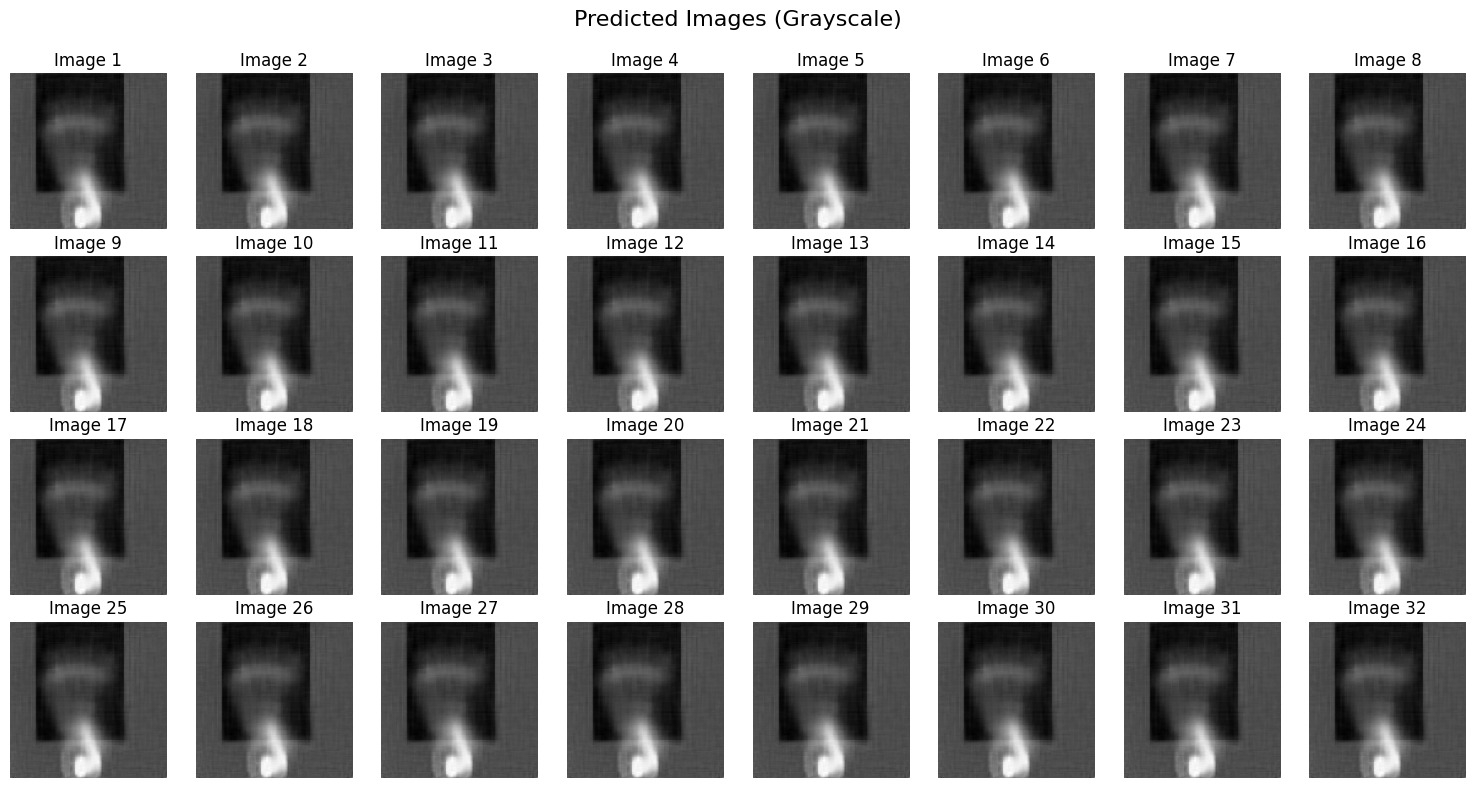

In [16]:
predicted_img = np.array(predicted_img)  # Nếu cần, convert thành np.array
num_images = 32  # Số lượng ảnh trong batch (32 ảnh)
cols = 8  # Số cột trong lưới ảnh
rows = num_images // cols  # Số hàng, đảm bảo đủ để chứa 32 ảnh

# Tạo một figure để hiển thị ảnh
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
fig.suptitle("Predicted Images (Grayscale)", fontsize=16)

# Plot từng ảnh trên các ô subplot
for i in range(rows * cols):
    ax = axes[i // cols, i % cols]  # Xác định vị trí hàng và cột
    ax.imshow(predicted_img[i, :, :, 0], cmap='gray')  # Plot ảnh, chỉ số cuối là kênh 0
    ax.axis("off")  # Tắt trục tọa độ
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Điều chỉnh tiêu đề không bị chèn lên các ảnh
plt.show()
